# Let's start with a raw Intel dataset

In [1]:
from fastai.vision.all import *
from fastbook import *

path = Path('/home/ilua/fastbook_book14/inteldata/')

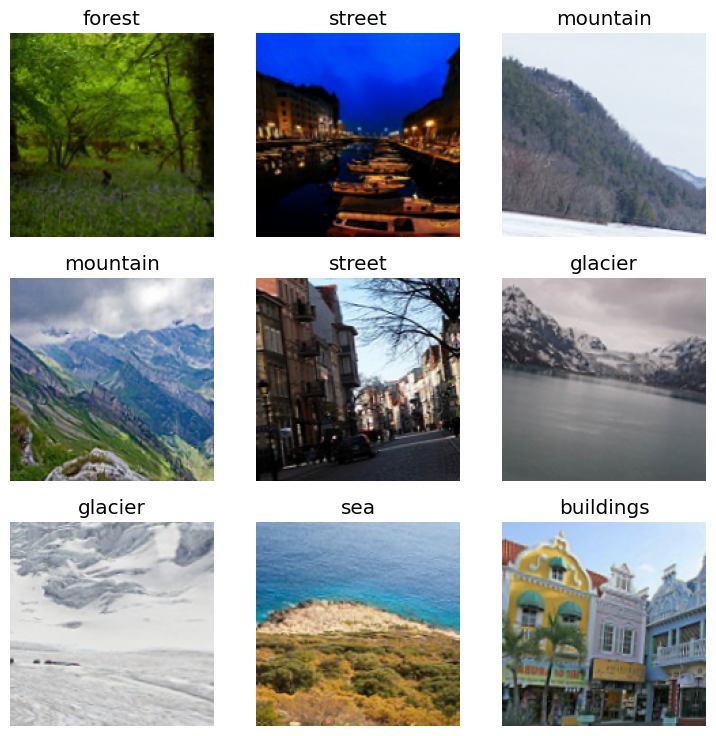

In [10]:
dls.show_batch()

### Setup with the intermediate Resnet architecture

In [3]:
def _conv_block(ni,nf,stride):
    return nn.Sequential(
        ConvLayer(ni, nf, stride=stride),
        ConvLayer(nf, nf, act_cls=None, norm_type=NormType.BatchZero))

class ResBlock(Module):
    def __init__(self, ni, nf, stride=1):
        self.convs = _conv_block(ni,nf,stride)
        self.idconv = noop if ni==nf else ConvLayer(ni, nf, 1, act_cls=None)
        self.pool = noop if stride==1 else nn.AvgPool2d(2, ceil_mode=True)

    def forward(self, x):
        return F.relu(self.convs(x) + self.idconv(self.pool(x)))

def block(ni, nf, stride=2):
    return nn.Sequential(ResBlock(ni, nf, stride=stride), ResBlock(nf, nf))

Making a dataset with specific batch size and seed

In [7]:
SEED = 66

In [8]:
dls = ImageDataLoaders.from_folder(
    path, 
    train="seg_train",
    valid="seg_test",
    seed=SEED,
    item_tfms=RandomResizedCrop(150, min_scale=0.70),
    batch_tfms=[*aug_transforms(), Normalize()],
    bs=128
)
    
def get_model():
    return nn.Sequential(
        block(3, 32),  #75
        block(32, 64), #38
        block(64, 64), #19
        block(64, 128),  #10
        block(128, 256),  #5
        nn.AdaptiveAvgPool2d(1),
        Flatten(),
        nn.Linear(256, 128),
        nn.Dropout(0.1),
        nn.Linear(128, dls.c))
    
def get_learner(m):
    return Learner(dls, m, loss_func=CrossEntropyLossFlat(), metrics=accuracy
                  ).to_fp16()

learn = get_learner(get_model())

Fitting the Learner with weight decay:

In [8]:
# Set a fixed random seed
random.seed(SEED)
np.random.seed(SEED)

In [11]:
learn.fit_one_cycle(20, 0.0022, wd=0.025)

epoch,train_loss,valid_loss,accuracy,time
0,0.230933,0.288077,0.897333,00:08
1,0.246827,0.316084,0.890667,00:08
2,0.282672,0.365779,0.870000,00:08
3,0.328299,0.429821,0.852000,00:09
4,0.329051,0.402179,0.856667,00:08
5,0.314662,0.406145,0.860333,00:08
6,0.321006,0.413320,0.847000,00:08
7,0.295781,0.455410,0.847333,00:08
8,0.274073,0.348062,0.877000,00:08
9,0.256240,0.375267,0.869333,00:08


In [12]:
learn.fit_one_cycle(20, 0.0022, wd=0.025)

epoch,train_loss,valid_loss,accuracy,time
0,0.118435,0.285941,0.904667,00:08
1,0.137129,0.334013,0.889333,00:08
2,0.172296,0.346340,0.892000,00:08
3,0.208513,0.401719,0.864000,00:08
4,0.228560,0.348602,0.880333,00:08
5,0.227683,0.365556,0.879333,00:08
6,0.214437,0.364873,0.878333,00:08
7,0.219999,0.322541,0.886667,00:08
8,0.202668,0.303847,0.899333,00:08
9,0.182060,0.298665,0.904000,00:08


Let's check a confusion matrix and top failures predictions:

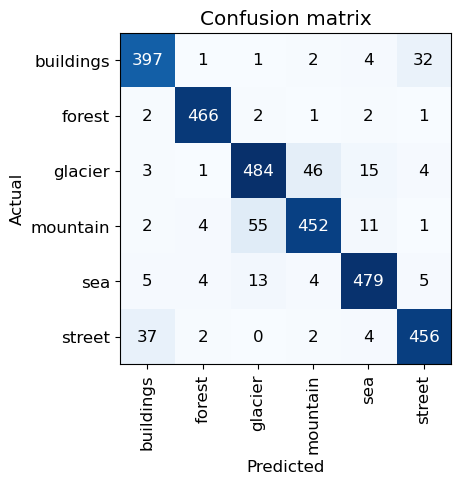

In [15]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

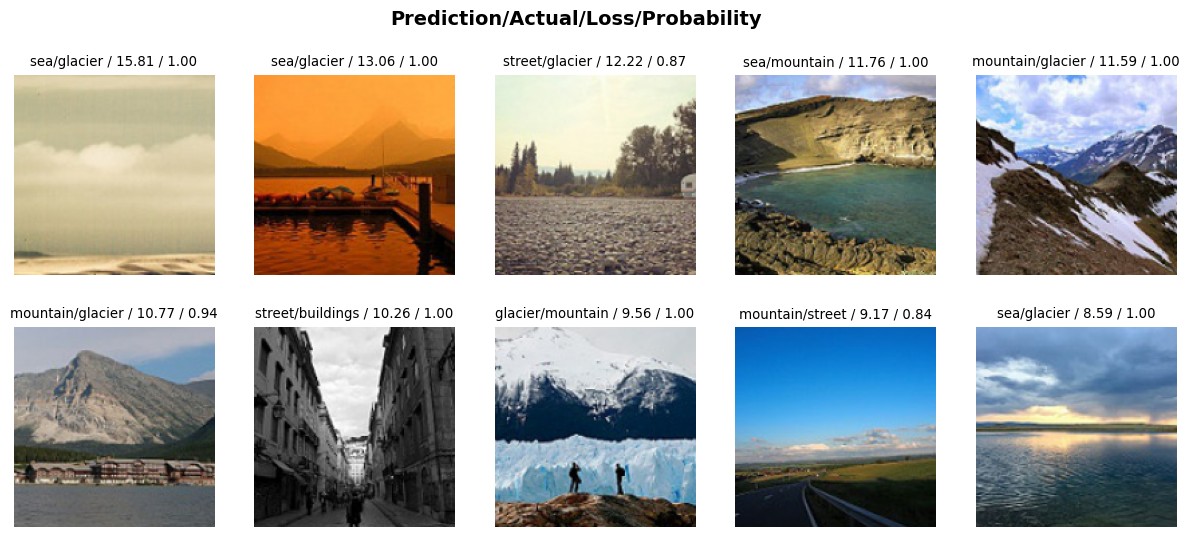

In [16]:
plt.rcParams.update({'font.size': 8})
interp.plot_top_losses(10, nrows=2)

As we can see there are a lot of failed Street/Building and Mountain/Glacier pairs

170 in total

There are a lot of mislabeled samples in the glacier folder. And we test it out how a net will work without wrong given samples

# Cleaned data

Let's make a hand cleaned train and valid folder and see how it will work

In [22]:
dls = ImageDataLoaders.from_folder(
    path, 
    train="clean_train",
    valid="clean_test",
    seed=SEED,
    item_tfms=RandomResizedCrop(150, min_scale=0.70),
    batch_tfms=[*aug_transforms(), Normalize()],
    bs=128
)
    
def get_model():
    return nn.Sequential(
        block(3, 32),  #75
        block(32, 64), #38
        block(64, 64), #19
        block(64, 128),  #10
        block(128, 256),  #5
        nn.AdaptiveAvgPool2d(1),
        Flatten(),
        nn.Linear(256, 128),
        nn.Dropout(0.1),
        nn.Linear(128, dls.c))
    
def get_learner(m):
    return Learner(dls, m, loss_func=CrossEntropyLossFlat(), metrics=accuracy
                  ).to_fp16()

learn = get_learner(get_model())

In [23]:
learn.fit_one_cycle(20, 0.0022, wd=0.025)

epoch,train_loss,valid_loss,accuracy,time
0,1.360190,1.208656,0.536626,00:09
1,1.045007,0.956029,0.636089,00:08
2,0.834801,0.683617,0.755040,00:08
3,0.702322,0.789287,0.702957,00:08
4,0.605518,0.543074,0.798387,00:08
5,0.530483,0.570483,0.786290,00:08
6,0.483038,0.627594,0.777554,00:08
7,0.450244,0.382082,0.857191,00:08
8,0.411093,0.373294,0.863575,00:08
9,0.378834,0.413188,0.846774,00:08


In [24]:
learn.fit_one_cycle(20, 0.0022, wd=0.025)

epoch,train_loss,valid_loss,accuracy,time
0,0.181675,0.259691,0.906250,00:08
1,0.211180,0.320181,0.887769,00:08
2,0.246263,0.319377,0.887097,00:08
3,0.279662,0.361473,0.873992,00:08
4,0.292011,0.546659,0.807124,00:08
5,0.299616,0.324252,0.883401,00:08
6,0.288008,0.353839,0.876680,00:08
7,0.270657,0.360454,0.878360,00:08
8,0.251505,0.383158,0.865927,00:08
9,0.235312,0.371252,0.874328,00:08


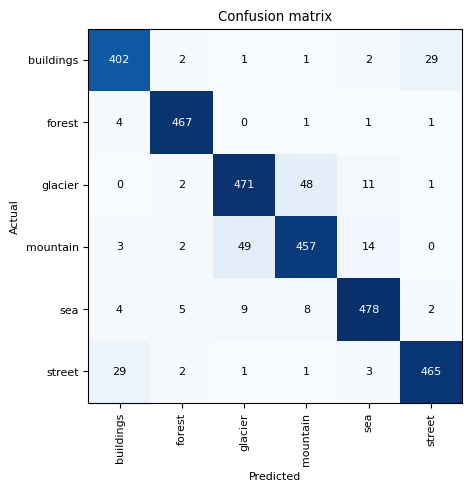

In [25]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

#### 149 wrong prediction in Street/Building and Mountain/Glacier pairs

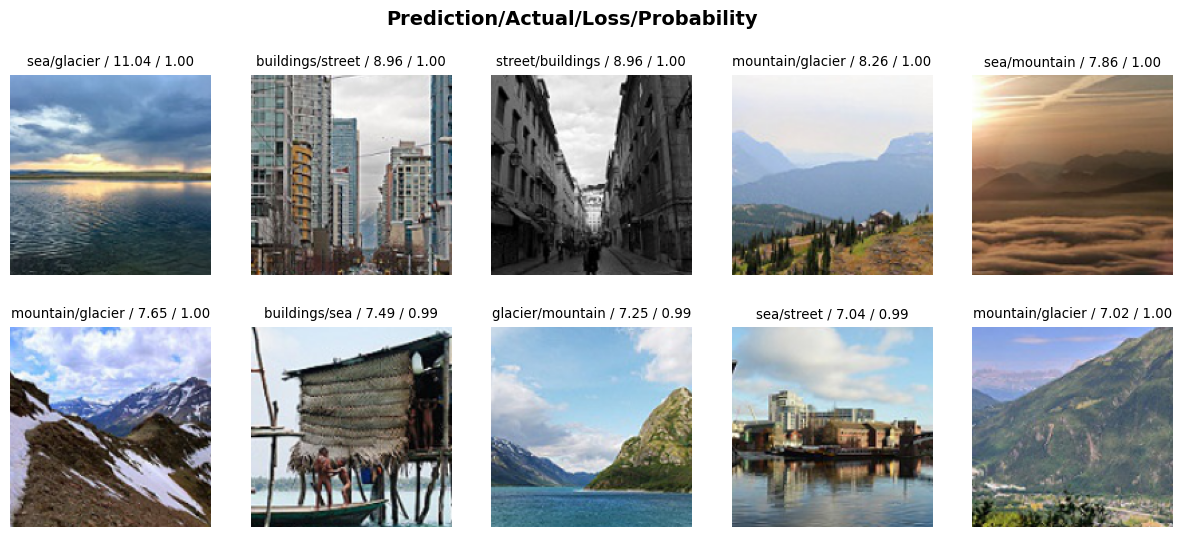

In [26]:
plt.rcParams.update({'font.size': 8})
interp.plot_top_losses(10, nrows=2)

# More Deep

In [18]:
dls = ImageDataLoaders.from_folder(
    path, 
    train="clean_train",
    valid="clean_test",
    seed=SEED,
    item_tfms=RandomResizedCrop(150, min_scale=0.70),
    batch_tfms=[*aug_transforms(), Normalize()],
    bs=128
)
    
def get_model():
    return nn.Sequential(
        block(3, 32),  #75
        block(32, 64), #38
        block(64, 64, stride=1), #38
        block(64, 64), #19
        block(64, 128),  #10
        block(128, 128, stride=1), #10
        block(128, 256,),  #5
        nn.AdaptiveAvgPool2d(1),
        Flatten(),
        nn.Linear(256, 128),
        nn.Dropout(0.1),
        nn.Linear(128, dls.c))
    
def get_learner(m):
    return Learner(dls, m, loss_func=CrossEntropyLossFlat(), metrics=accuracy
                  ).to_fp16()

learn = get_learner(get_model())

In [19]:
learn.fit_one_cycle(20, 0.001, wd=0.025)

epoch,train_loss,valid_loss,accuracy,time
0,1.509312,1.371150,0.493280,00:09
1,1.156427,0.978490,0.604167,00:09
2,0.896566,0.879122,0.656922,00:09
3,0.759347,0.692729,0.748656,00:09
4,0.652264,0.587689,0.785618,00:09
5,0.579637,0.499256,0.815188,00:09
6,0.523456,0.485377,0.822245,00:09
7,0.482760,0.477813,0.827957,00:09
8,0.432513,0.498742,0.808132,00:09
9,0.398251,0.465755,0.824597,00:09


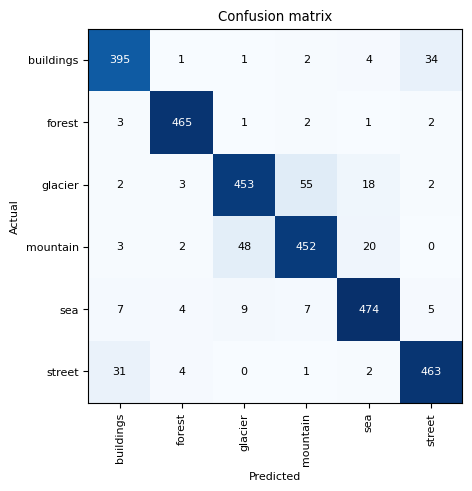

In [20]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

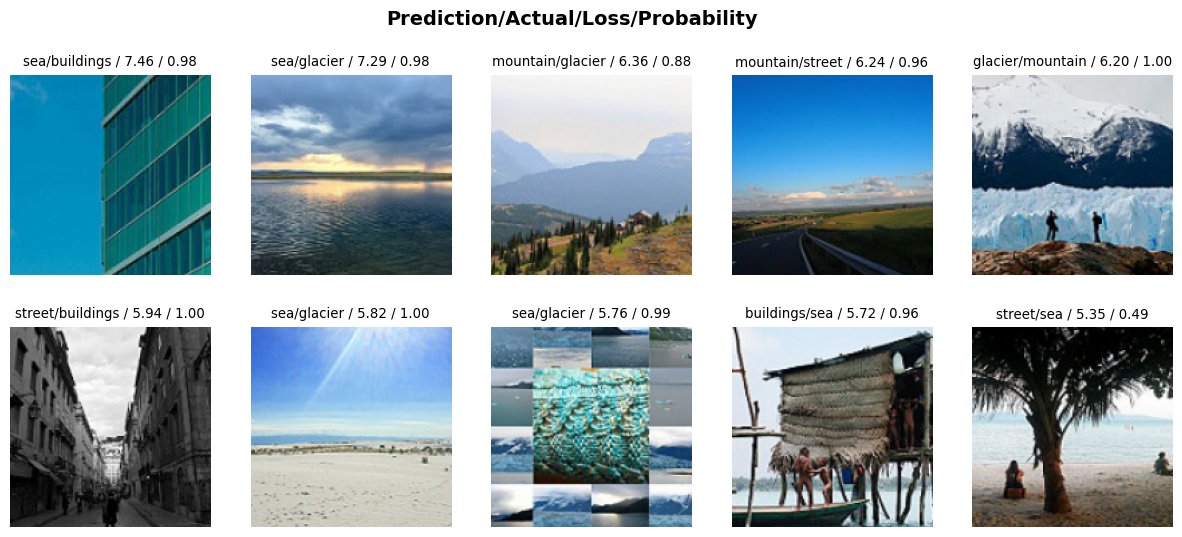

In [21]:
plt.rcParams.update({'font.size': 8})
interp.plot_top_losses(10, nrows=2)